# 1. Setup

## 1.1 Install/Import Dependencies

In [1]:
!pip list -v

Package                      Version     Location                                                                   Installer
---------------------------- ----------- -------------------------------------------------------------------------- ---------
absl-py                      2.3.1       /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
anyio                        4.11.0      /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
apt-listchanges              4.8         /usr/lib/python3/dist-packages                                             debian
argon2-cffi                  25.1.0      /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
argon2-cffi-bindings         25.1.0      /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
arrow                        1.4.0       /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
asgiref                  

In [2]:
#Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from picamera2 import Picamera2

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.2 Create Folder Structure

In [20]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)



## 2. Collect Positives and Anchors

In [ ]:
#!unzip '/home/nasir/FacialRecognitionSiameseModel/lfw.zip' -d '/home/nasir/FacialRecognitionSiameseModel/lfw'

In [ ]:
#Move LFW Images to the following Repository data/negative
'''for directory in os.listdir('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled'):
    for file in os.listdir(os.path.join('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled',directory)):
        EX_PATH = os.path.join('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH, NEW_PATH)'''

In [5]:
# Import uuid library to generate unique image names
import uuid

In [6]:
uuid.uuid1()

UUID('098199cc-ccb4-11f0-b9b9-2ccf67db9bc7')

In [ ]:

# Initialize the camera
picam2 = Picamera2()
    
# Create a preview configuration (640x480 is good for testing)
config = picam2.create_preview_configuration(main={"format": "XRGB8888", "size": (250, 250)})
picam2.configure(config)
    
# Start the camera
picam2.start()
    
print("Press 'q' to quit the camera feed.")
    
# Continuously capture frames and display them
while True:
    frame = picam2.capture_array()
    #Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
        
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    cv2.imshow("PiCamera2 Feed", frame)
    
    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
# Clean up
cv2.destroyAllWindows()
picam2.stop()





In [ ]:
frame.shape

## 3. Load and Preprocess Images

### 3.1 Get Image Directories

In [21]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [22]:
dir_test = anchor.as_numpy_iterator()

In [23]:
dir_test.next()

b'data/anchor/1c62952e-b83b-11f0-a223-2ccf67db9bc7.jpg'

### 3.2 Preprocessing - Scale and Resize

In [24]:
def preprocess(file_path):
    #reads in image from the file_path in byte like format
    #byte like format is any object that supports the buffer protocol
	byte_img = tf.io.read_file(file_path)
    #Load/decode the image 
	img = tf.io.decode_jpeg(byte_img)
    #resize the image to 100 by 100 by 3 array
	img = tf.image.resize(img,(100,100))
    #pixel value is between 0 and 255
    #Scaling down the pixel value down by 255 to be between 0 and 1S
	img = img / 255.0
    #returns the image
	return img

In [25]:
img = preprocess('data/anchor/0860061a-b83b-11f0-a223-2ccf67db9bc7.jpg')

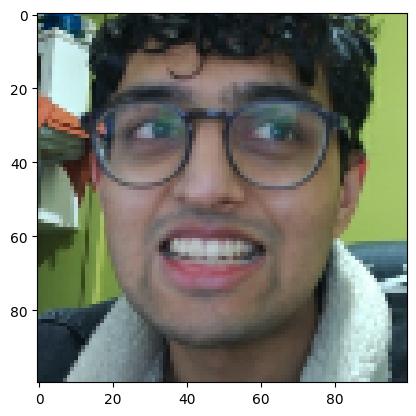

In [26]:
plt.imshow(img)

In [27]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

### 3.3 Create Labelled Dataset

In [28]:
#zips dataset and creates labelled dataset for positive images filled with 1 
#zipping allows us to iterate through all at same time
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
#zips dataset and creates labelled dataset for negative images filled with 0
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
#joining positives and negatives together to create one dataset
data = positives.concatenate(negatives)

In [29]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [30]:
samples = data.as_numpy_iterator()

In [31]:
example=samples.next()
example

(b'data/anchor/08ea8cea-b83b-11f0-a223-2ccf67db9bc7.jpg',
 b'data/positive/10ac08dc-b83b-11f0-a223-2ccf67db9bc7.jpg',
 np.float32(1.0))

#### 3.3.1 Build Train and Test Partition 

In [32]:
#passes the input and validation image through preprocessing 
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [33]:
res = preprocess_twin(*example)

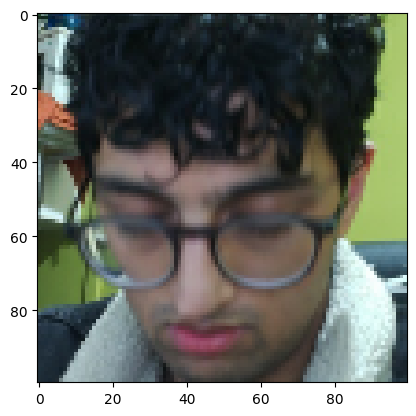

In [34]:
plt.imshow(res[1])

In [35]:
#Build dataloader pipeline
data = data.map(preprocess_twin)#applies preprocess_twin function to every item in data
data = data.cache()#Caching stores the results, so they only need to run once
data = data.shuffle(buffer_size=1024)#Randomizes the order of elements in the dataset

In [36]:
samples = data.as_numpy_iterator()

In [37]:
sample = samples.next()

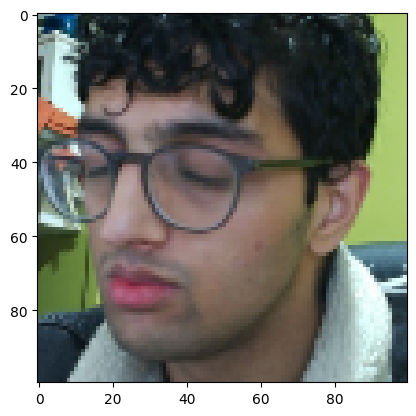

In [38]:
plt.imshow(sample[0])#anchor image

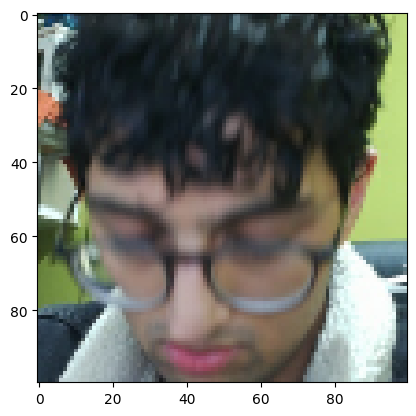

In [39]:
plt.imshow(sample[1])#positive/negative image

In [40]:
sample[2]#label 1=positive, 0=negative

np.float32(1.0)

In [41]:
round(len(data))

600

In [42]:
#Training partition
train_data = data.take(round(len(data)*0.7))#takes the data and splits it for training data
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [43]:
#Testing partition
test_data = data.skip(round(len(data)*0.7))#skips the training data 
test_data = test_data.take(round(len(data)*0.3))

## 4.0 Build Model

### 4.1 Embedding Layer

In [44]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')#input layer
    
    c1 = Conv2D(64,(10,10), activation='relu')(inp)#64 filters @ 10x10 pixels
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)#64 filters and shape is 2x2
    
    c2 = Conv2D(128,(7,7), activation='relu')(m1)#128 filters @ 7x7 pixels
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)#64 filters and shape is 2x2
    
    c3 = Conv2D(128,(4, 4), activation='relu')(m2)#128 filters @ 4x4 pixels
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)#64 filters and shape is 2x2

    c4 = Conv2D(256,(4, 4), activation='relu')(m3)#256 filters @ 4x4 pixels
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)#4096 vectors
    
    return Model(inputs=inp, outputs=d1, name='embedding')#returns embedding 

In [45]:
embeddingLayer = make_embedding()

In [46]:
embeddingLayer.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Distance Layer

In [47]:
class L1Dist(Layer):#passes base Layer class
    def __init__(self, **kwargs):#basic init method
        super().__init__()
        
    #standard Keras Siamese distance layer
    def call(self, input_embedding, validation_embedding):#input = anchor, validation = pos/neg img
        return tf.math.abs(input_embedding - validation_embedding)#similarity calculation

### 4.3 Siamese Model

In [48]:
def make_siamese_model(): 
    
    # Anchor image 
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combines siamese distance layer components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embeddingLayer(input_image), embeddingLayer(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork') # return siamese model

In [49]:
siamese_model = make_siamese_model()

In [50]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [53]:
checkpoint_dir = '/home/nasir/FacialRecognitionSiameseModel/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

## 5.3 Train Step Function

In [54]:
@tf.function #complies function into a callable tensorflow graph
def train_step(batch):
    with tf.GradientTape() as tape:#Records operations for automatic differentiation
        # Get anchor and positve/negative image
        X = batch[:2] #16 img per batch
        #get label
        y = batch[2]

        #Forward pass
        yhat = siamese_model(X, training=True)#perdiction
        #Calculate loss
        loss = binary_cross_loss(y, yhat)

    #Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables) 

    #Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

## 5.4 Build Training Loop

In [55]:
def train(data, EPOCHS):
    # Loop through the epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch{}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(train_data))
    
        #Loop through each batch
        for idx, batch in enumerate(train_data):
            #Run training
            train_step(batch)
            progbar.update(idx+1)
    
        #Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [56]:
EPOCHS = 50

## 5.5 Train the model

In [57]:
train(train_data,EPOCHS)


 Epoch1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 708s 26s/step

 Epoch2/50


2025-11-29 01:54:43.113845: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 717s 26s/step


2025-11-29 02:06:39.989727: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 717s 27s/step

 Epoch4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 708s 26s/step

 Epoch5/50


2025-11-29 02:31:14.559347: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 712s 26s/step

 Epoch6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 714s 26s/step

 Epoch7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 708s 26s/step

 Epoch8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 705s 26s/step

 Epoch9/50


2025-11-29 03:18:33.328391: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 706s 26s/step

 Epoch10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 699s 26s/step

 Epoch11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 699s 26s/step

 Epoch12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 708s 26s/step

 Epoch13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 709s 26s/step

 Epoch14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 701s 26s/step

 Epoch15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 707s 26s/step

 Epoch16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 707s 26s/step

 Epoch17/50


2025-11-29 04:54:23.180074: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 705s 26s/step

 Epoch18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 705s 26s/step

 Epoch19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 706s 26s/step

 Epoch20/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 705s 26s/step

 Epoch21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 699s 26s/step

 Epoch22/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 706s 26s/step

 Epoch23/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 698s 26s/step

 Epoch24/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 707s 26s/step

 Epoch25/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 708s 26s/step

 Epoch26/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 706s 26s/step

 Epoch27/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 706s 26s/step

 Epoch28/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 705s 26s/step

 Epoch29/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 704s 26s/step

 Epoch30/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 704s 26s/step

 Epoch31/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 703s 26s/step

 Epoch32/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 704s 26s/step

 Epoch33/50


2025-11-29 08:03:27.605469: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 704s 26s/step

 Epoch34/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 704s 26s/step

 Epoch35/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 695s 26s/step

 Epoch36/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 705s 26s/step

 Epoch37/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 696s 26s/step

 Epoch38/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 704s 26s/step

 Epoch39/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 703s 26s/step

 Epoch40/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 705s 26s/step

 Epoch41/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 704s 26s/step

 Epoch42/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 706s 26s/step

 Epoch43/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 709s 26s/step

 Epoch44/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 700s 26s/step

 Epoch45/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 699s 26s/step

 Epoch46/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 708s 26s/step

 Epoch47/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 701s 26s/step

 Epoch48/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 709s 26s/step

 Epoch49/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 709s 26s/step

 Epoch50/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 701s 26s/step
